In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset and take a smaller subset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
subset_size = 1000
x_train = x_train[:subset_size] / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200] / 255.0
y_test = y_test[:200]



29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
#ADVERSARIAL TRAINING
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def generate_adversarial_examples(model, x, y, epsilon=0.1):
    # Generate adversarial examples using Fast Gradient Sign Method (FGSM)
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradient = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradient)
    x_adv = x_tensor + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

In [5]:

# Train model with Adversarial Training
model_adv = create_model()
x_adv = generate_adversarial_examples(model_adv, x_train, y_train, epsilon=0.1)

x_combined = np.concatenate([x_train, x_adv])
y_combined = np.concatenate([y_train, y_train])

history_adv = model_adv.fit(x_combined, y_combined, epochs=5,
                            validation_data=(x_test, y_test), verbose=1)

loss_adv, accuracy_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%')


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2360 - loss: 2.2839 - val_accuracy: 0.6750 - val_loss: 1.0501
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6690 - loss: 1.0188 - val_accuracy: 0.7200 - val_loss: 0.7777
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.7693 - loss: 0.7058 - val_accuracy: 0.7500 - val_loss: 0.7140
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8529 - loss: 0.5104 - val_accuracy: 0.7750 - val_loss: 0.6216
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8874 - loss: 0.4228 - val_accuracy: 0.7950 - val_loss: 0.5797

Adversarially Trained Model Accuracy: 79.50%


In [6]:
# 2. TANGENT PROP
class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape=tf.shape(x),
                                        stddev=0.1)
        return x + perturbation

# Apply Tangent Prop to the model
model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())
history_tangent_prop = model_tangent_prop.fit(x_train, y_train, epochs=5, 
                                              validation_data=(x_test, y_test), verbose=0)
loss, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f'Adversarially Trained Model with Tangent Prop Accuracy: {accuracy_tangent_prop * 100:.2f}%')

# TANGENT DISTANCE
def tangent_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# TANGENT CLASSIFIER
def classify_with_tangent_distance(x_train, y_train, x_test):
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    y_pred = []

    print(f"\nClassifying {len(x_test_flat)} test samples...")

    for i, test_sample in enumerate(x_test_flat):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(x_test_flat)}")
        distances = [tangent_distance(test_sample, train_sample)
                     for train_sample in x_train_flat]
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])

    return np.array(y_pred)

y_pred_tangent = classify_with_tangent_distance(x_train, y_train, x_test)
accuracy_tangent = np.mean(y_pred_tangent == y_test)
print(f'\nTangent Distance Classifier Accuracy: {accuracy_tangent * 100:.2f}%')



Adversarially Trained Model with Tangent Prop Accuracy: 73.00%

Classifying 200 test samples...
Progress: 20/200
Progress: 40/200
Progress: 60/200
Progress: 80/200
Progress: 100/200
Progress: 120/200
Progress: 140/200
Progress: 160/200
Progress: 180/200
Progress: 200/200

Tangent Distance Classifier Accuracy: 77.50%


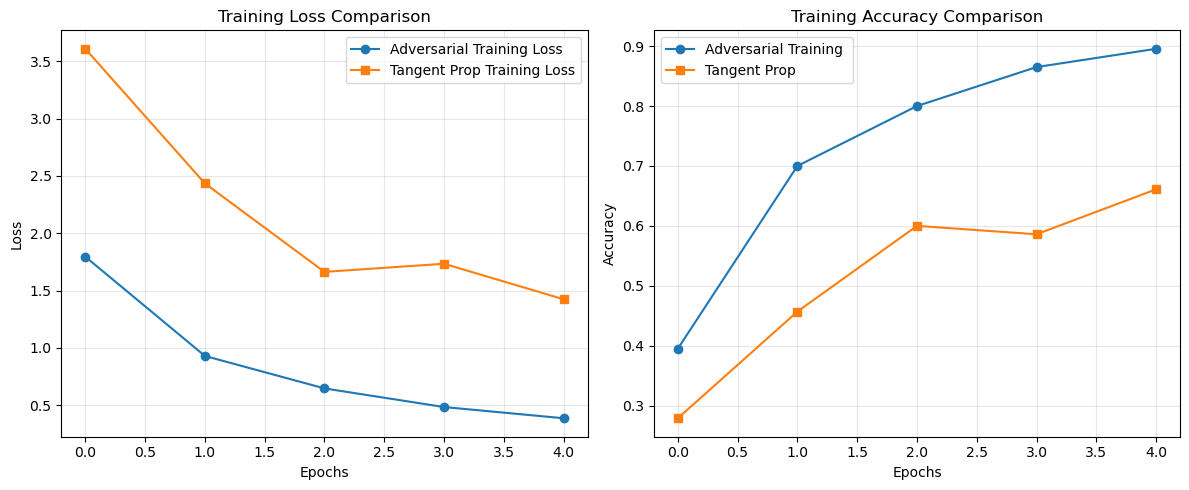

Adversarial Training Accuracy:    79.50%
Tangent Prop Accuracy:    73.00%
Tangent distance classifier:    77.50%


In [8]:
# Plot training loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'],
         label='Adversarial Training Loss', marker='o')
plt.plot(history_tangent_prop.history['loss'],
         label='Tangent Prop Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True,alpha=0.3)
plt.subplot(1,2,2)
plt.plot(history_adv.history['accuracy'],
         label='Adversarial Training ', marker='o')
plt.plot(history_tangent_prop.history['accuracy'],
         label='Tangent Prop', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Adversarial Training Accuracy:    {accuracy_adv*100:.2f}%")
print(f"Tangent Prop Accuracy:    {accuracy_tangent_prop*100:.2f}%")
print(f"Tangent distance classifier:    {accuracy_tangent*100:.2f}%")